In [1]:
import statsmodels.api as sm
import scipy.stats as sts
import numpy as np
import pandas as pd
import sympy as sp
import pylab
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

import warnings

warnings.filterwarnings("ignore")

1) Выбрать ряд с биржи с 01.01.2023 по 15.04.2024
2) Проверить ряд на стационарность
3) Определить тип и порядок процесса по ACF и PACF
4) Построить модели AR, MA, ARMA, ARIMA, SARIMA
5) Прогноз на 5 периодов вперед

# 1. Выбрать ряд с биржи с 01.01.2023 по 15.04.2024

## Импорт данных

In [2]:
df = pd.read_excel('GOLD_close_price.xlsx', sheet_name='GOLD_CLOSE').iloc[:-10,:]
df

,DATE,GOLD_CLOSE
0,2023-01-04,1810.1
1,2023-01-05,1822.4
2,2023-01-06,1809.7
3,2023-01-07,1827.8
4,2023-01-10,1835.9
...,...,...
320,2024-04-09,2372.9
321,2024-04-10,2386.6
322,2024-04-11,2365.7
323,2024-04-12,2415.5


DATE - дата торговой сессии с 01.01.2023 по 15.04.2024

GOLD_CLOSE - цена фьючерса на золото в долларах США на закрытие торговой сессии

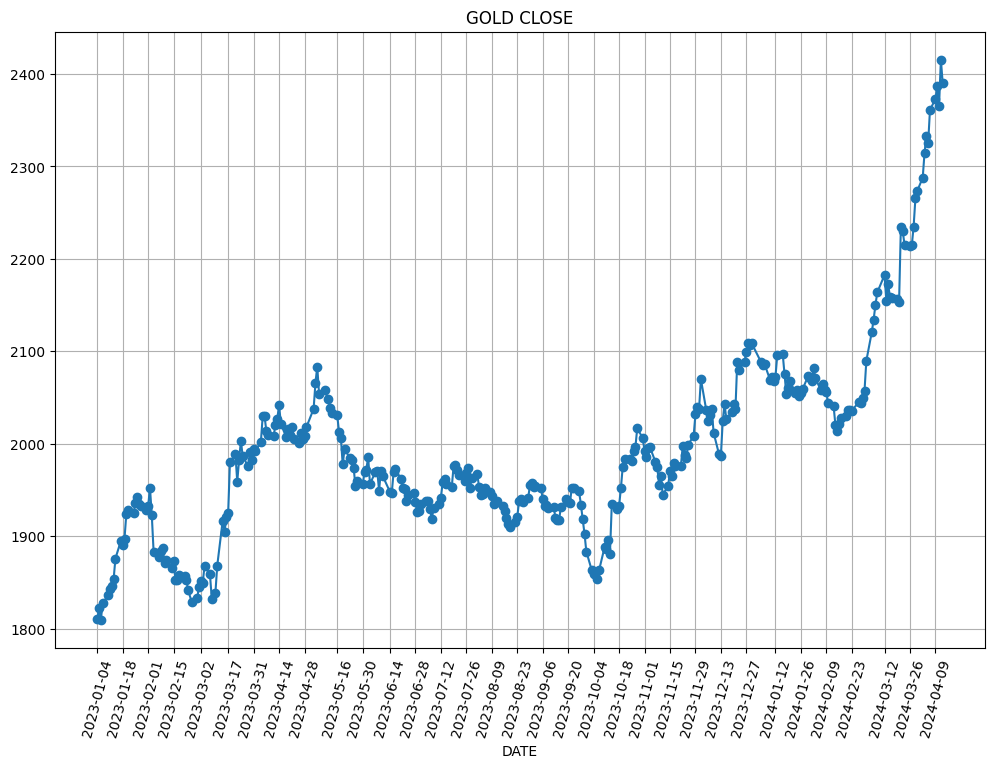

In [3]:
plt.figure(figsize=(12,8))
plt.plot(df["DATE"], df["GOLD_CLOSE"], marker='o', label="Точки")
plt.xlabel("DATE")
plt.title("GOLD CLOSE")
plt.grid(True)
plt.xticks(df["DATE"][::10], rotation=75)
plt.show()

## Расчет доходности

Временной промежуток менее 10 лет, значит выберу для построения ряд доходности, для дальнейшей работы с ним 

In [6]:
gold_close = df['GOLD_CLOSE'].values
profit_gold = [0]+[(gold_close[i] - gold_close[i-1])/gold_close[i-1] for i in range(1, len(gold_close))]

In [7]:
df['GOLD_PROF'] = profit_gold

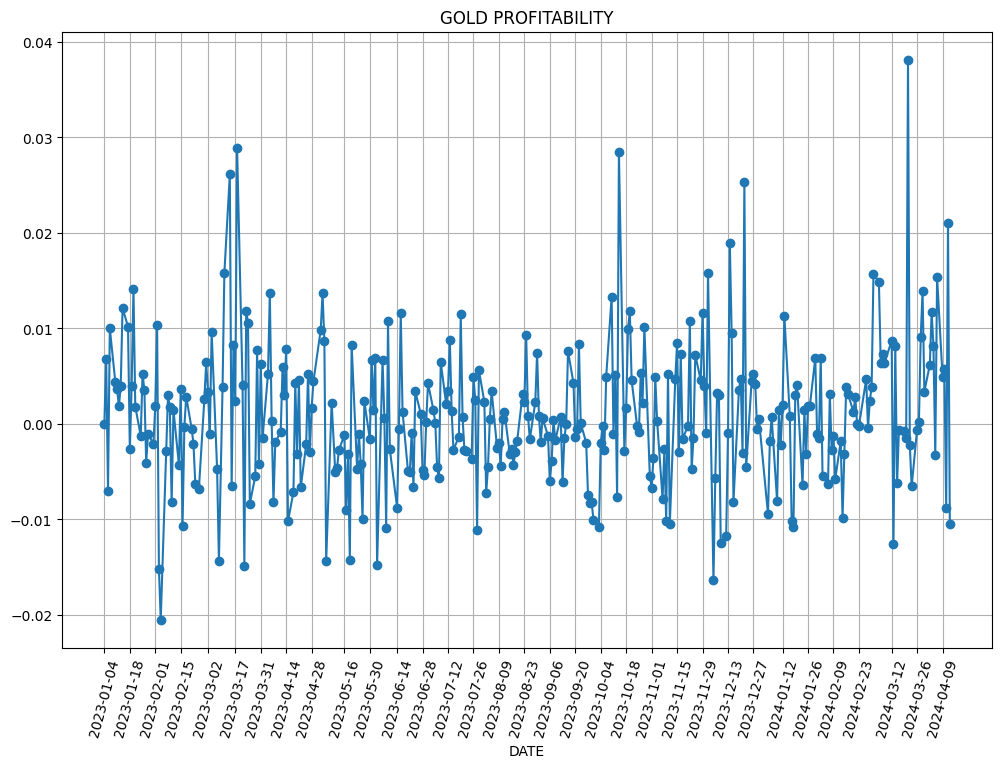

In [8]:
plt.figure(figsize=(12,8))
plt.plot(df["DATE"], df["GOLD_PROF"], marker='o', label="Точки")
plt.xlabel("DATE")
plt.title("GOLD PROFITABILITY")
plt.grid(True)
plt.xticks(df["DATE"][::10], rotation=75)
plt.show()

# 2. Проверить ряд на стационарность

Проверю ряд на стационарность с помощью интеграционной статистики Дарбина-Уотсона

H0: Ряд стационарен

H1: Ряд нестационарен

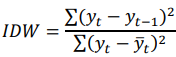

In [9]:
y = np.array(profit_gold)
IDW = sum([(y[i] - y[i-1])**2 for i in range(1, len(y))]) / sum([(y[i] - y.mean())**2 for i in range(len(y))])
print(f'IDW = {round(IDW, 5)}')

IDW = 1.94024


Значение IDW близко к 2, значит гипотеза H0 не отклоняется. 

**Вывод: Исходя из интеграционной статистики Дарбина-Уотсона, ряд признается стационарным**

# 3. Определить тип и порядок процесса по ACF и PACF

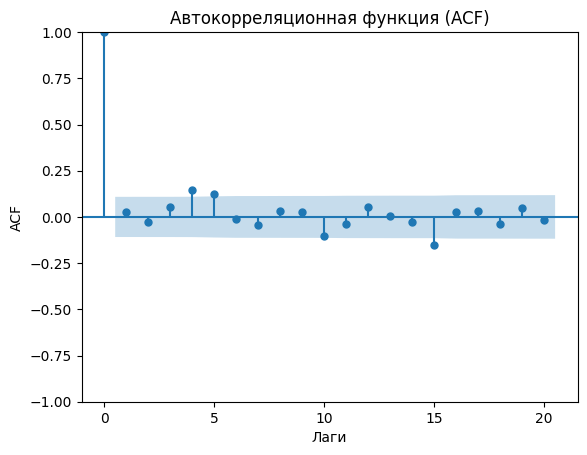

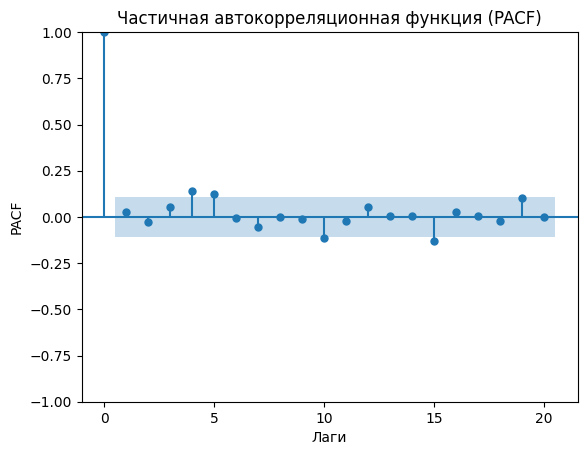

In [10]:
data = df['GOLD_PROF']
plot_acf(data, lags=20)
plt.title('Автокорреляционная функция (ACF)')
plt.xlabel('Лаги')
plt.ylabel('ACF')
plt.show()

plot_pacf(data, lags=20)
plt.title('Частичная автокорреляционная функция (PACF)')
plt.xlabel('Лаги')
plt.ylabel('PACF')
plt.show()

В ACF и в PACF наблюдается сезонность. Значит лучшей моделью будет SARIMA, но без несезонной части, т.к первые значимые лаги начинают появляться только через определенный период, а не сразу

p = 1 или 0 - определяется по PACF. Присутствуют значимые лаги с периодичностью = 5. Т.к. только в первом случае два значимых лага стоят подряд, значит выбирать буду между 1 и 0, т.к. значимые лаги лишь не на много выходят за порог значимости

q = 1 или 0 - определяется по ACF. Присутствуют значимые лаги с периодичностью = 5. Т.к. только в первом случае два значимых лага стоят подряд, значит выбирать буду между 1 и 0, т.к. значимые лаги лишь не на много выходят за порог значимости

d = 0 - данные стационарны

s = 5 - периодичность значимых лагов

# 4. Построить модели AR, MA, ARMA, ARIMA, SARIMA

Сравню модель SARIMA с другими моделями, чтобы убедиться в выборе лучшей модели

Также возьму три модели SARIMA, чтобы найти лучшие параметры

Для сравнения буду использовать критерии Акайке, Шварца и Ханнан-Куина

In [11]:
AR_1 = ARIMA(data, order=(1,0,0), trend='n').fit()
AR_2 = ARIMA(data, order=(2,0,0), trend='n').fit()
MA_1 = ARIMA(data, order=(0,0,1), trend='n').fit()
MA_2 = ARIMA(data, order=(0,0,2), trend='n').fit()
ARMA_11 = ARIMA(data, order=(1,0,1), trend='n').fit()
ARMA_12 = ARIMA(data, order=(1,0,2), trend='n').fit()
ARMA_21 = ARIMA(data, order=(2,0,1), trend='n').fit()
ARMA_22 = ARIMA(data, order=(2,0,2), trend='n').fit()
ARIMA_111 = ARIMA(data, order=(1,1,1), trend='n').fit()
SARIMA_11 = ARIMA(data, seasonal_order=(1,0,1,5), trend='n').fit()
SARIMA_10 = ARIMA(data, seasonal_order=(1,0,0,5), trend='n').fit()
SARIMA_01 = ARIMA(data, seasonal_order=(0,0,1,5), trend='n').fit()


models_list = [AR_1, AR_2, MA_1, MA_2, ARMA_11, ARMA_12, ARMA_21, ARMA_22, ARIMA_111, SARIMA_11, SARIMA_10, SARIMA_01]
model_names = ['AR_1', 'AR_2', 'MA_1', 'MA_2', 'ARMA_11', 'ARMA_12',
               'ARMA_21', 'ARMA_22', 'ARIMA_111', 'SARIMA_11', 'SARIMA_10', 'SARIMA_01']

k_list = [2, 3, 2, 3, 3, 4, 4, 5, 3, 3, 2, 2]
T = len(data)
AIC_list_new = [np.log(m.sse / T) + 2*k_list[i]/T for i, m in enumerate(models_list)]
BIC_list_new = [np.log(m.sse / T) + k_list[i] * np.log(T)/T for i, m in enumerate(models_list)]
HQIC_list_new = [np.log(m.sse / T) + 2*k_list[i] * np.log(np.log(T))/T for i, m in enumerate(models_list)]

In [12]:
print(f'Лучшая модель по критерию Акайке: {model_names[AIC_list_new.index(min(AIC_list_new))]}')

Лучшая модель по критерию Акайке: SARIMA_01


In [13]:
print(f'Лучшая модель по критерию Шварца: {model_names[BIC_list_new.index(min(BIC_list_new))]}')

Лучшая модель по критерию Шварца: SARIMA_01


In [14]:
print(f'Лучшая модель по критерию Ханнан-Куина: {model_names[HQIC_list_new.index(min(HQIC_list_new))]}')

Лучшая модель по критерию Ханнан-Куина: SARIMA_01


**Вывод: все критерии показали, что лучшей моделью является модель SARIMA с параметрами:**

p = 0

d = 0

q = 1

s = 5

In [15]:
SARIMA_01 = ARIMA(data, seasonal_order=(0,0,1,5), trend='n').fit()

print(SARIMA_01.summary())

                                SARIMAX Results                                
Dep. Variable:               GOLD_PROF   No. Observations:                  325
Model:             ARIMA(0, 0, [1], 5)   Log Likelihood                1128.416
Date:                 Sun, 28 Apr 2024   AIC                          -2252.831
Time:                         22:35:39   BIC                          -2245.263
Sample:                              0   HQIC                         -2249.811
                                 - 325                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L5        0.1318      0.057      2.330      0.020       0.021       0.243
sigma2      5.644e-05   3.15e-06     17.906      0.000    5.03e-05    6.26e-05
Ljung-Box (L1) (Q):                   0.03  

$ y_t =  \Theta_1*\varepsilon_{t-5}\ + \varepsilon_t\ $

$ y_t = {0.1314}*\varepsilon_{t-5}\ + \varepsilon_t\ $

$ \sigma^2 = {5.644}*{10}^{-5}$

# 5. Прогноз на 10 периодов вперед

Для прогноза возьму 10 периодов, т.к. периодичность модели 5

In [16]:
test_df = pd.read_excel('GOLD_close_price.xlsx', sheet_name='GOLD_CLOSE').iloc[-11:,:]
test_gold_close = test_df['GOLD_CLOSE'].values
test_prof = [(test_gold_close[i]-test_gold_close[i-1])/(test_gold_close[i-1]) for i in range(1, len(test_gold_close))]
test_prof

[0.010585331157692224,
 0.0006624161629543384,
 -0.005213074058750479,
 0.0012893029446015259,
 0.005316718587746701,
 -0.02379870264016872,
 -0.0028780632327420866,
 -0.005178488051275637,
 0.006528139266971107,
 0.004959728698601025]

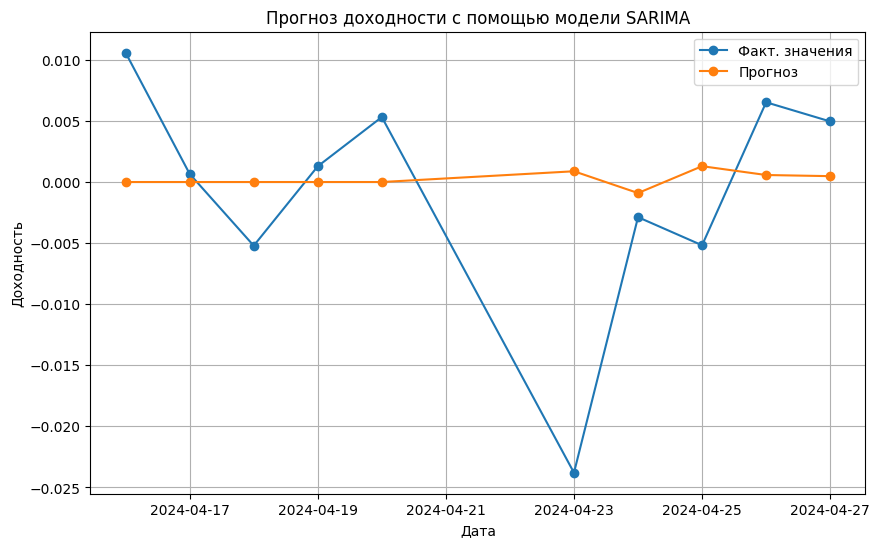

In [18]:
sarima_predict = SARIMA_01.predict(start=1, end=len(test_prof), exog=test_prof)
plt.figure(figsize=(10, 6))
plt.plot(test_df['DATE'][1:], test_prof, label='Факт. значения',marker='o')
plt.plot(test_df['DATE'][1:], sarima_predict, label='Прогноз',marker='o')
plt.grid()
plt.xlabel('Дата')
plt.ylabel('Доходность')
plt.title('Прогноз доходности с помощью модели SARIMA')
plt.legend();

**Вывод: прогнозные значения редко приближены к реальным данным из-за наличия в данных белого шума**

In [19]:
sarima_predict_price = [test_gold_close[0]]
for i in range(len(sarima_predict)):
    pred_price = test_gold_close[i]*(1 + list(sarima_predict)[i])
    sarima_predict_price.append(pred_price)
sarima_predict_price

[2390.1,
 2390.1,
 2415.4,
 2417.0,
 2404.4,
 2407.5,
 2422.429942677328,
 2360.5676191818206,
 2358.9515817737374,
 2345.0450998912306,
 2360.1339549037334]

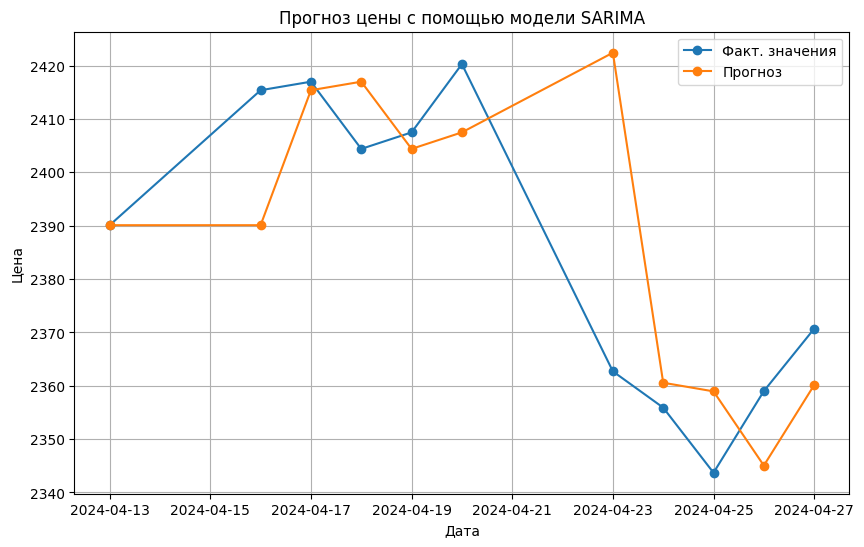

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(test_df['DATE'], test_gold_close, label='Факт. значения',marker='o')
plt.plot(test_df['DATE'], sarima_predict_price, label='Прогноз',marker='o')
plt.grid()
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.title('Прогноз цены с помощью модели SARIMA')
plt.legend();

**Вывод: если брать предыдущую цену закрытия и текущую спрогнозированную доходность, то модель довольно близко описывает фактические значения. Это произошло из-за того, что использумая модель эффективна только на малых временных промежутках.**